In [81]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from dowhy import CausalModel

# Data Cleaning

In [82]:
data = pd.read_csv(
    "../data/banks.csv"
)

data.head()

,date,weekday,day,month,year,bib6,bio6,bib8,bio8
0,10775,Monday,1,7,1929,141,141,169,169
1,10776,Tuesday,2,7,1929,141,141,169,169
2,10777,Wednesday,3,7,1929,141,141,169,169
3,10778,Thursday,4,7,1929,141,141,169,169
4,10779,Friday,5,7,1929,141,141,169,169


In [83]:
data['date'] = data[['year', 'month', 'day']].apply(
    lambda row: datetime.date(row.iloc[0], row.iloc[1], row.iloc[2]),
    axis=1
)

data['date'] = pd.to_datetime(data['date'])

for col in ['bib6', 'bio6', 'bib8', 'bio8']:
    data[f'l{col}'] = data[col].apply(lambda x: np.log(x))

data = data[(data['month']==7) & (data['day']==1)]

data

,date,weekday,day,month,year,bib6,bio6,bib8,bio8,lbib6,lbio6,lbib8,lbio8
0,1929-07-01,Monday,1,7,1929,141,141,169,169,4.948760,4.948760,5.129899,5.129899
365,1930-07-01,Tuesday,1,7,1930,135,135,165,165,4.905275,4.905275,5.105945,5.105945
730,1931-07-01,Wednesday,1,7,1931,121,121,132,130,4.795791,4.795791,4.882802,4.867534
1096,1932-07-01,Friday,1,7,1932,113,111,120,118,4.727388,4.709530,4.787492,4.770685
1461,1933-07-01,Saturday,1,7,1933,102,100,111,110,4.624973,4.605170,4.709530,4.700480
1826,1934-07-01,Sunday,1,7,1934,102,102,109,108,4.624973,4.624973,4.691348,4.682131


In [84]:
did_data = pd.concat(
    [
        data[['date', 'year', 'bib6']].rename(columns={"bib6": "bib"}).assign(state=1),
        data[['date', 'year', 'bib8']].rename(columns={"bib8": "bib"}).assign(state=0),
    ],
    axis=0
).reset_index(drop=True)

did_data['post'] = (did_data['date'] > pd.to_datetime('1931-01-01')).astype(int)
did_data['treated'] = did_data['post'] * did_data['state']

did_data

,date,year,bib,state,post,treated
0,1929-07-01,1929,141,1,0,0
1,1930-07-01,1930,135,1,0,0
2,1931-07-01,1931,121,1,1,1
3,1932-07-01,1932,113,1,1,1
4,1933-07-01,1933,102,1,1,1
5,1934-07-01,1934,102,1,1,1
6,1929-07-01,1929,169,0,0,0
7,1930-07-01,1930,165,0,0,0
8,1931-07-01,1931,132,0,1,0
9,1932-07-01,1932,120,0,1,0


# Causal Inference

According to Equation(5.3) in the book, the reduced form of DID equation is as follows:

$Y_{dt} = \alpha + \beta TREAT_{d} + \gamma POST_{t} + \delta_{rDID} (TREAT_{d} \times POST_{t}) + \epsilon_{dt}$,

where:
* $TREAT_{d}$ is the state-fixed effect, which is renamed "state" in the data cleaning process above
* $POST_{t}$ is the time-fixed effect, renamed "post"
* $TREAT_{d} \times POST_{t}$ is the treatment variable, renamed "treated"

Regression upon 12 data points, the estimated causal effect should be around 20.5 with the standard error arround 10.7

## `DoWhy` Implementation

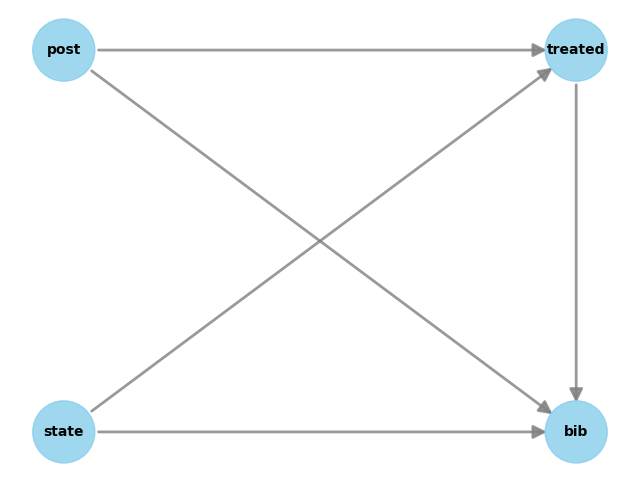

In [85]:
dowhy_did_model = CausalModel(
    data=did_data,
    treatment='treated',
    outcome='bib',
    common_causes=['post', 'state'],
)

dowhy_did_model.view_model()

In [86]:
identified_estimand = dowhy_did_model.identify_effect()
identified_estimand.estimands

{'backdoor1': {'estimand': Derivative(Expectation(bib|post,state), [treated]),
  'assumptions': {'Unconfoundedness': 'If U→{treated} and U→bib then P(bib|treated,post,state,U) = P(bib|treated,post,state)'}},
 'backdoor2': {'estimand': Derivative(Expectation(bib|post,state), [treated]),
  'assumptions': {'Unconfoundedness': 'If U→{treated} and U→bib then P(bib|treated,post,state,U) = P(bib|treated,post,state)'}},
 'backdoor': {'estimand': Derivative(Expectation(bib|post,state), [treated]),
  'assumptions': {'Unconfoundedness': 'If U→{treated} and U→bib then P(bib|treated,post,state,U) = P(bib|treated,post,state)'}},
 'iv': None,
 'frontdoor': None}

In [87]:
causal_estimate_reg = dowhy_did_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)

print(causal_estimate_reg)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                        
──────────(E[bib|post,state])
d[treated]                   
Estimand assumption 1, Unconfoundedness: If U→{treated} and U→bib then P(bib|treated,post,state,U) = P(bib|treated,post,state)

## Realized estimand
b: bib~treated+post+state
Target units: ate

## Estimate
Mean value: 20.500000000000043
p-value: [0.09222442]



/home/davidli/anaconda3/envs/mastering-py-metrics/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/davidli/anaconda3/envs/mastering-py-metrics/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## `statsmodels` Implementation

Similar to `R`'s formula api, in `statsmodels`, asterisk (*) represents generating the product of two dummy variables without removing them; colon (:) represents generating and leaving only the product but not the original variables. More information can be found in `statsmodels`' [documentation on R-styled formulas](https://www.statsmodels.org/devel/example_formulas.html).

In [88]:
formula = 'bib ~ post*state'

results = smf.ols(
    formula=formula,
    data=did_data
).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    bib   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     21.71
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           0.000337
Time:                        14:15:51   Log-Likelihood:                -40.628
No. Observations:                  12   AIC:                             89.26
Df Residuals:                       8   BIC:                             91.20
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    167.0000      6.190     26.980      0.0

/home/davidli/anaconda3/envs/mastering-py-metrics/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Plot

In [89]:
plot_data = data.copy()
plot_data.head()

,date,weekday,day,month,year,bib6,bio6,bib8,bio8,lbib6,lbio6,lbib8,lbio8
0,1929-07-01,Monday,1,7,1929,141,141,169,169,4.948760,4.948760,5.129899,5.129899
365,1930-07-01,Tuesday,1,7,1930,135,135,165,165,4.905275,4.905275,5.105945,5.105945
730,1931-07-01,Wednesday,1,7,1931,121,121,132,130,4.795791,4.795791,4.882802,4.867534
1096,1932-07-01,Friday,1,7,1932,113,111,120,118,4.727388,4.709530,4.787492,4.770685
1461,1933-07-01,Saturday,1,7,1933,102,100,111,110,4.624973,4.605170,4.709530,4.700480


In [90]:
# calculate counterfactual benchmarking with 1930
plot_data['bib6_cf'] = (
    plot_data['bib8'] 
    / plot_data.set_index('year').loc[1930, 'bib8'] 
    * plot_data.set_index('year').loc[1930, 'bib6']
).astype(int)

plot_data

,date,weekday,day,month,year,bib6,bio6,bib8,bio8,lbib6,lbio6,lbib8,lbio8,bib6_cf
0,1929-07-01,Monday,1,7,1929,141,141,169,169,4.948760,4.948760,5.129899,5.129899,138
365,1930-07-01,Tuesday,1,7,1930,135,135,165,165,4.905275,4.905275,5.105945,5.105945,135
730,1931-07-01,Wednesday,1,7,1931,121,121,132,130,4.795791,4.795791,4.882802,4.867534,108
1096,1932-07-01,Friday,1,7,1932,113,111,120,118,4.727388,4.709530,4.787492,4.770685,98
1461,1933-07-01,Saturday,1,7,1933,102,100,111,110,4.624973,4.605170,4.709530,4.700480,90
1826,1934-07-01,Sunday,1,7,1934,102,102,109,108,4.624973,4.624973,4.691348,4.682131,89


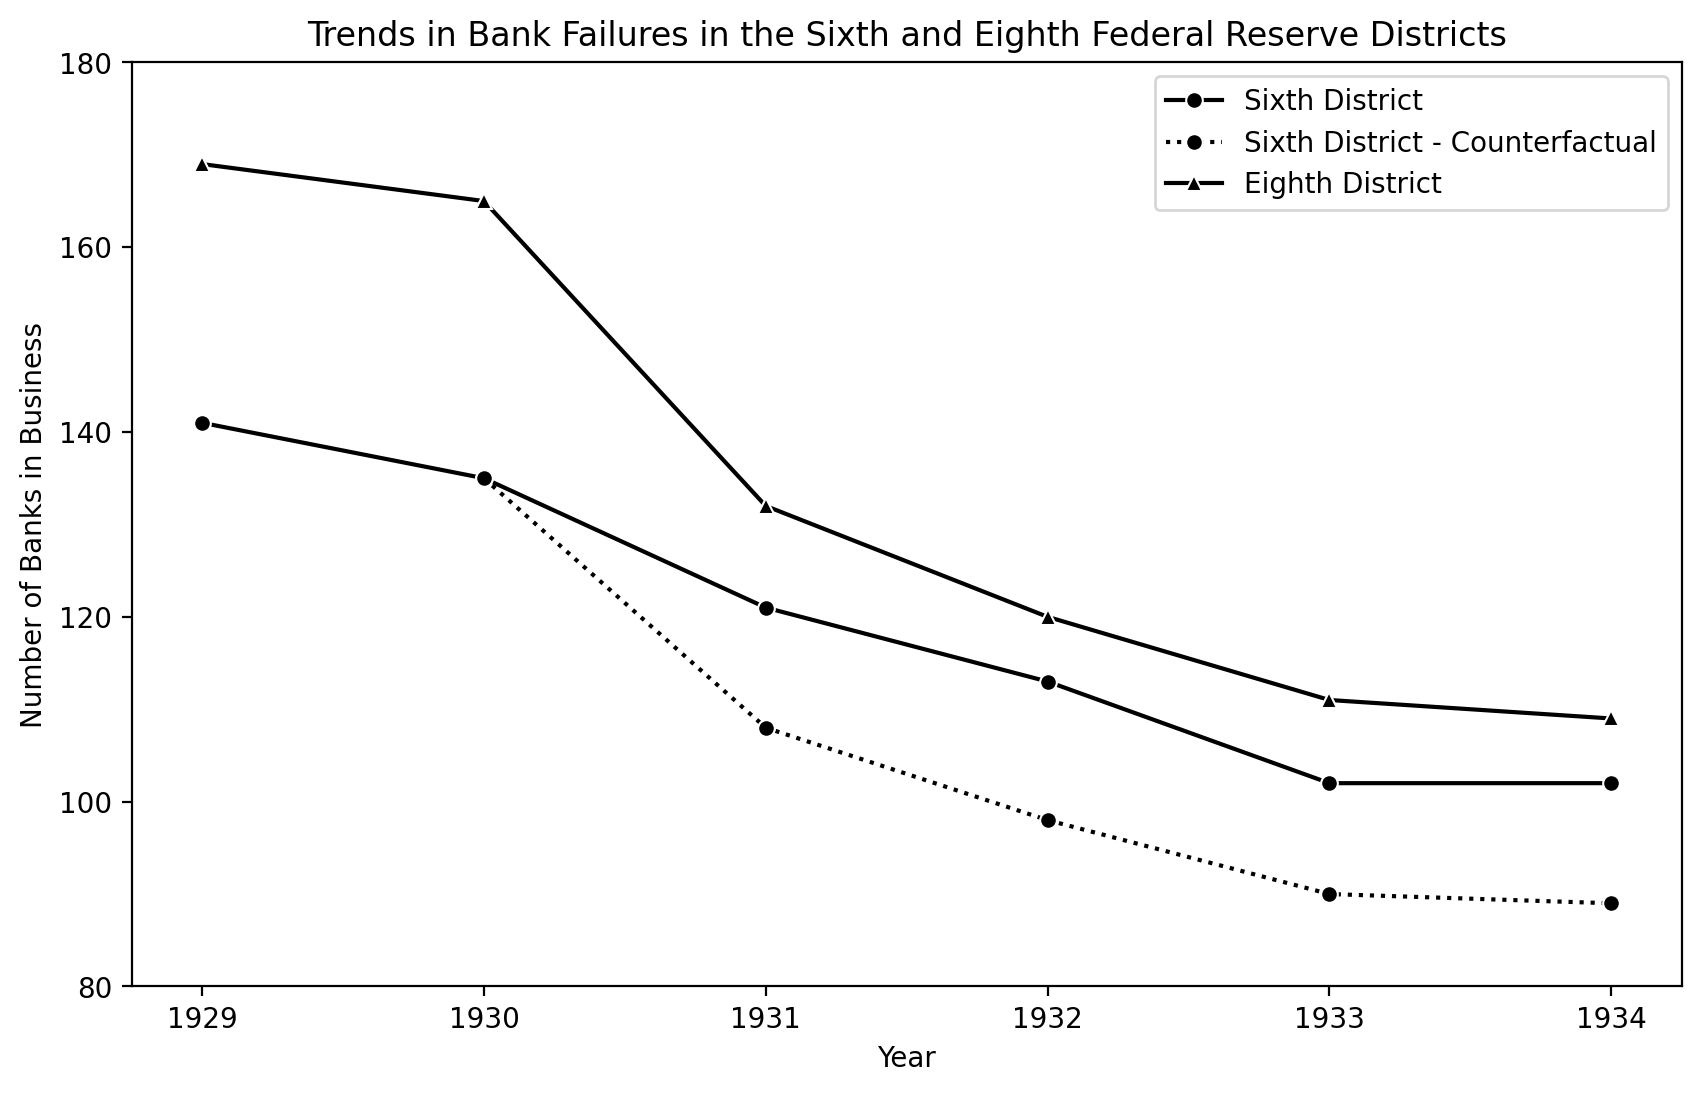

In [91]:
ax: plt.Axes
fig, ax = plt.subplots(figsize=(10,6), dpi=200)

sns.lineplot(
    data=plot_data,
    x="year",
    y="bib6",
    marker="o",
    color='black',
    label="Sixth District"
)

sns.lineplot(
    data=plot_data[plot_data['year'] >= 1930],
    x="year",
    y="bib6_cf",
    marker="o",
    linestyle=":",
    color='black',
    label="Sixth District - Counterfactual"
)

sns.lineplot(
    data=plot_data,
    x="year",
    y="bib8",
    marker="^",
    color='black',
    label="Eighth District"
)

ax.set_title("Trends in Bank Failures in the Sixth and Eighth Federal Reserve Districts")
ax.set_xlabel("Year")
ax.set_ylim([80, 180])
ax.set_ylabel("Number of Banks in Business")

plt.legend()
plt.savefig("../figs/banks.png")